# Corpus semantic & syntactic analysis
In this notebooks, I'll explore the following analyses of corpus semantics and syntactics:
1. **Vocabulary analysis.** Look for out-of-vocabulary words in each pairwise comparison of corpora. The more out-of-vocabulary words for a given pair, the less similar they are to one another. Expect that SciERC and PICKLE will have more overlapping vocabulary.
2. **Token analysis.** Using a word2vec model, embed the tokens from each corpus, and see how they cluster in the vector space. Expect that PICKLE and SciERC tokens will cluster together in space.
3. **Document analysis.** Using some kind of document embedding (doc2vec, a BERT based embedding, etc), perform the same style of analysis as for the tokens. Expect PICKLE and SciERC documents to cluster together more often.

In [13]:
from gensim.models import KeyedVectors
import jsonlines
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Importing my own Dataset class
import sys
sys.path.append('../models/corpus_comparison/')
from dataset import Dataset

## 1. Vocabulary analysis
For this analysis, we'll use the SciERC, GENIA, and PICKLE corpora to get the sets of tokens that make up the three corpora. We'll then look for out-of-vocabulary words in each pairwise comparison of corpora. Based on the pre-trained model results, in which SciERC outperformed GENIA on the PICKLE corpus, we expect to see that there are more out-of-vocabulary words in the GENIA-PICKLE comparison than in the SciERC-PICKLE comparison.
### Getting our corpus vocabularies
First, we have to get the GENIA and SciERC datasets.

#### Downloading SciERC and GENIA data
We'll use the code provided in the [DyGIE++](https://github.com/dwadden/dygiepp) repo for this purpose, running the following commands from the root of the `dygiepp` repo:

```
bash ./scripts/data/get_scierc.sh
```

```
bash ./scripts/data/get_genia.sh
```

### Comparing vocabularies
Now that we have all three datasets, we can compare them. This is done with the script `out_of_vocab_comparison.py`, found in the `models/corpus_comparison` directory.

<br>

*A summary of the comparisons:* For each pair of datasets, a total of 6 metrics were calculated. For each of unigrams, bigrams, and trigrams, the datasets were compared in both directions, and a percentage of out-of-vocabulary words for that comparison was calculated. For example, The number of unigrams in PICKLE, but not in GENIA, divided by the total number of unigrams in PICKLE, makes up the out-of-vocabulary fraction for the PICKLE --> GENIA direction comparison.

#### Commands used to generate comparisons
The relative paths here are specific to my local filesystem/data directory structure, which doesn't come along with this repository. These commands were run form the `models/corpus_comparison/` directory.

To compare GENIA to PICKLE:
```
python out_of_vocab_comparison.py genia ../../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json pickle ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_ENTITIES_all_gold_standard_abstracts_GOLD_STD_03Mar2022.jsonl ../../data/straying_off_topic_data/corpus_comparison/ genia_vs_pickle
```

To compare SciERC to PICKLE:
```
python out_of_vocab_comparison.py scierc ../../../dygiepp/data/scierc/processed_data/json/train.json pickle ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_ENTITIES_all_gold_standard_abstracts_GOLD_STD_03Mar2022.jsonl ../../data/straying_off_topic_data/corpus_comparison/ scierc_vs_pickle
```

To compare SciERC to GENIA:
```
python out_of_vocab_comparison.py scierc ../../../dygiepp/data/scierc/processed_data/json/train.json genia ../../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json ../../data/straying_off_topic_data/corpus_comparison/ scierc_vs_genia
```

#### Looking at comparison outputs
Now, lets read in the data and see what the situation is.

In [2]:
genia_vs_pickle_path = '../data/straying_off_topic_data/corpus_comparison/genia_vs_pickle_oov_comparison.jsonl'
scierc_vs_pickle_path = '../data/straying_off_topic_data/corpus_comparison/scierc_vs_pickle_oov_comparison.jsonl'
scierc_vs_genia_path = '../data/straying_off_topic_data/corpus_comparison/scierc_vs_genia_oov_comparison.jsonl'

In [3]:
genia_vs_pickle = []
with jsonlines.open(genia_vs_pickle_path) as reader:
    for obj in reader:
        genia_vs_pickle.append(obj)
        
scierc_vs_pickle = []
with jsonlines.open(scierc_vs_pickle_path) as reader:
    for obj in reader:
        scierc_vs_pickle.append(obj)
        
scierc_vs_genia = []
with jsonlines.open(scierc_vs_genia_path) as reader:
    for obj in reader:
        scierc_vs_genia.append(obj)

To better visualize the situation, let's make a bar plot!

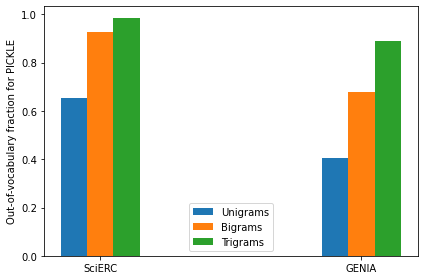

In [27]:
pickle_labels = ['SciERC', 'GENIA']
unigrams = [scierc_vs_pickle[0]['unigrams_oov_pickle_frac'], genia_vs_pickle[0]['unigrams_oov_pickle_frac']]
bigrams = [scierc_vs_pickle[0]['bigrams_oov_pickle_frac'], genia_vs_pickle[0]['bigrams_oov_pickle_frac']]
trigrams = [scierc_vs_pickle[0]['trigrams_oov_pickle_frac'], genia_vs_pickle[0]['trigrams_oov_pickle_frac']]

x = np.arange(len(pickle_labels))
width = 0.1

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, unigrams, width, label='Unigrams')
rects2 = ax.bar(x, bigrams, width, label='Bigrams')
rects3 = ax.bar(x + width, trigrams, width, label='Trigrams')

ax.set_ylabel('Out-of-vocabulary fraction for PICKLE')
ax.set_xticks(x, pickle_labels)
ax.legend()

fig.tight_layout()

In all three categories, the fraction of PICKLE's vocabulary that is out of the vocabulary of the other corpus is much greater for SciERC than for GENIA. This is the opposite of what we expected, since SciERC performs better for entity recognition on the PICKLE corpus than GENIA does. However, it's possible that the semantics of the words in SciERC are more similar to those in PICKLE than in GENIA, which could account for the phenomenon. That's what we'll look at next.

-----------
## Token Analysis
Now, lets generate word vectors for the unigram, bigram, and trigram tokens in the three corpora, and compare their semantics by looking at how those vectors cluster.

<br>

We'll use the script `models/corpus_comparison/train_word2vec.py` to generate these word vectors, and read them in here. This script uses all the uni-, bi-, and trigrams from all three corpora to train a new Word2Vec model using the [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html).

### Code to generate the word vectors
The following command was used to generate the word vectors:
```
python train_word2vec.py -corpora ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_ENTITIES_all_gold_standard_abstracts_GOLD_STD_03Mar2022.jsonl ../../../dygiepp/data/scierc/processed_data/json/train.json ../../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json -out_loc ../../data/straying_off_topic_data/corpus_comparison/ -out_prefix pickle_scierc_genia_combined -v
```

### Reading in and plotting the word vectors
Now we want to take a look at the differences between the vectors from the different corpora. In order to do this, we're going to read them in, sort them to the corpus from which they came, and then using PCA to generate 2-D versions of the vectors that we can visualize.

In [5]:
# Import the word vectors
word2vecs = '../data/straying_off_topic_data/corpus_comparison/pickle_scierc_genia_combined_word2vec_skipgram.wordvectors'
vecs = KeyedVectors.load(word2vecs)

In [6]:
# Import the datasets
def read_dataset(path, name):
    """
    Read in a dataset to a Dataset object.
    """
    objs = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            objs.append(obj)
            
    dset = Dataset(name, objs)
    
    return dset

In [7]:
scierc_path = '../../dygiepp/data/scierc/processed_data/json/train.json'
genia_path = '../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json'
pickle_path = '../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_ENTITIES_all_gold_standard_abstracts_GOLD_STD_03Mar2022.jsonl'

scierc = read_dataset(scierc_path, 'scierc')
genia = read_dataset(genia_path, 'genia')
pickle = read_dataset(pickle_path, 'pickle')

In [8]:
# Sort vectors
# Heads up that this is slow
sep_vecs = {}
for dset in [scierc, genia, pickle]:
    _ = dset.get_dataset_vocab()
    dset_comb_vocab = list(dset.vocab['unigrams']) + list(dset.vocab['bigrams']) + list(dset.vocab['trigrams'])
    dset_vecs = {k:vecs[k] for k in vecs.index_to_key if k in dset_comb_vocab}
    sep_vecs[dset.get_dataset_name()] = dset_vecs

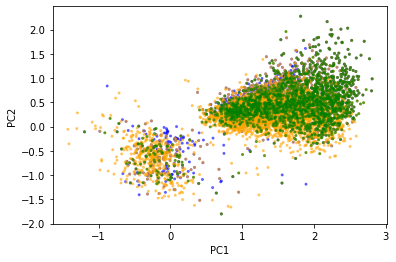

In [28]:
# Do PCA to get plottable shaped vectors
# Fit on all the vectors, then transform each individually to keep the sorted structure

# Make input array
X = []
for k in vecs.index_to_key:
    X.append(vecs[k])

# Fit PCA
pca = PCA(n_components=2)
pca.fit(X)

# Transform the vectors
x, y, group = [], [], []
for dset in sep_vecs:
    for word in sep_vecs[dset]:
        word_vec = sep_vecs[dset][word].reshape(1, -1)
        transformed = pca.transform(word_vec).flatten()
        x.append(transformed[0])
        y.append(transformed[1])
        group.append(dset)
        
# Plot
color_dict = {'scierc': 'blue', 'genia':'orange', 'pickle':'green'}
colors = [color_dict[i] for i in group]
scatter = plt.scatter(x=x, y=y, c=colors, alpha = 0.5, s=4)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Generally speaking, it looks like all three corpora form two clusters. There are no telling visual differences between the three corpora here, but it might be helpful to see what typical words from those two clusters look like for each of the corpora. (See lab notebook for next steps)